<h1><center>Polio cases analisis and predictions</center></h1>

Smart introduction #TODO

<h3>Imports</h3>

In [1]:
from cmdstanpy import CmdStanModel, CmdStanMCMC
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

global_seed = 29042020

<h3>Used Functions</h3>

In [2]:
def select_data(country: str, n_last_years: int = None) -> pd.DataFrame:
    import_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
    selected_data = {}
    if n_last_years:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][-n_last_years-1:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][-n_last_years-1:-1].to_numpy().flatten()
    else:
        selected_data['Cases'] = import_data[import_data['Entity'] == country][['Total (reported) polio cases']][:-1].to_numpy().flatten()
        selected_data['Year'] = import_data[import_data['Entity'] == country][['Year']][:-1].to_numpy().flatten()
    return selected_data

def plot_selected_data(selected_data: pd.DataFrame) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.legend(['Total (reported) polio cases for selected data'], prop={'size': 20})
    plt.xlabel('Year')
    plt.ylabel('Number of cases')
    plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
    plt.show()
    
def plot_distributions(fitted_model: CmdStanMCMC) -> None:
    plt.figure(figsize=(26, 6))
    plt.grid(True)
    plt.subplot(131)
    plt.hist(fitted_model.stan_variable('alpha'), bins = 30, density = True)
    plt.title('Alpha distribution')
    plt.subplot(132)
    plt.hist(fitted_model.stan_variable('beta'), bins = 30, density = True)
    plt.title('Beta distribution')
    plt.subplot(133)
    plt.hist(fitted_model.stan_variable('sigma'), bins = 30, density = True)
    plt.title('Sigma distribution')
    plt.show()
    
def plot_predictions_chart(selected_data: pd.DataFrame, pred_variable: np.ndarray, pred_year: int|str, quantiles: bool = True) -> None:
    plt.figure(figsize=(26, 10))
    plt.grid(True)
    plt.locator_params(axis="both", integer=True, tight=True)
    plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
    plt.plot([pred_year-1, pred_year], [selected_data['Cases'][-1], int(np.mean(pred_variable))], linewidth=5)
    if quantiles:
        plt.scatter(pred_year,np.quantile(pred_variable,0.95), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.75), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.5), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.25), linewidth=0.5)
        plt.scatter(pred_year,np.quantile(pred_variable,0.05), linewidth=0.5)
        plt.legend(['Total polio cases [imported data]','Total predicted polio cases', 'Quantile 0.95', 'Quantile 0.75','Quantile 0.5','Quantile 0.25','Quantile 0.05'], prop={'size': 20})
    else:
        plt.legend(['Total polio cases [imported data]','Total predicted polio cases'], prop={'size': 20})
    plt.title('Model chart with predicted data')
    plt.show()
    print(f'Predicted mean value of Polio cases for year {pred_year}: {int(np.mean(pred_variable))}')

<h3>Importing world data</h3>

Source: https://ourworldindata.org/polio 

In [3]:
imported_data = pd.read_csv('reported-vs-estimated-total-number-of-paralytic-polio-cases-globally.csv', delimiter=',')
world_data = imported_data[imported_data['Entity'] == 'World'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]  #2021 data is incomplete
world_data.reset_index(inplace=True)
world_data.describe()

,index,Year,Total (reported) polio cases,Total (estimated) polio cases
count,41.000000,41.000000,41.000000,41.000000
mean,7642.000000,2000.000000,13153.390244,87584.902439
std,11.979149,11.979149,17926.259126,126481.340420
min,7622.000000,1980.000000,42.000000,49.000000
25%,7632.000000,1990.000000,784.000000,1139.000000
50%,7642.000000,2000.000000,2971.000000,20797.000000
75%,7652.000000,2010.000000,23053.000000,131538.000000
max,7662.000000,2020.000000,65737.000000,460159.000000


<h3>Print imported data</h3>

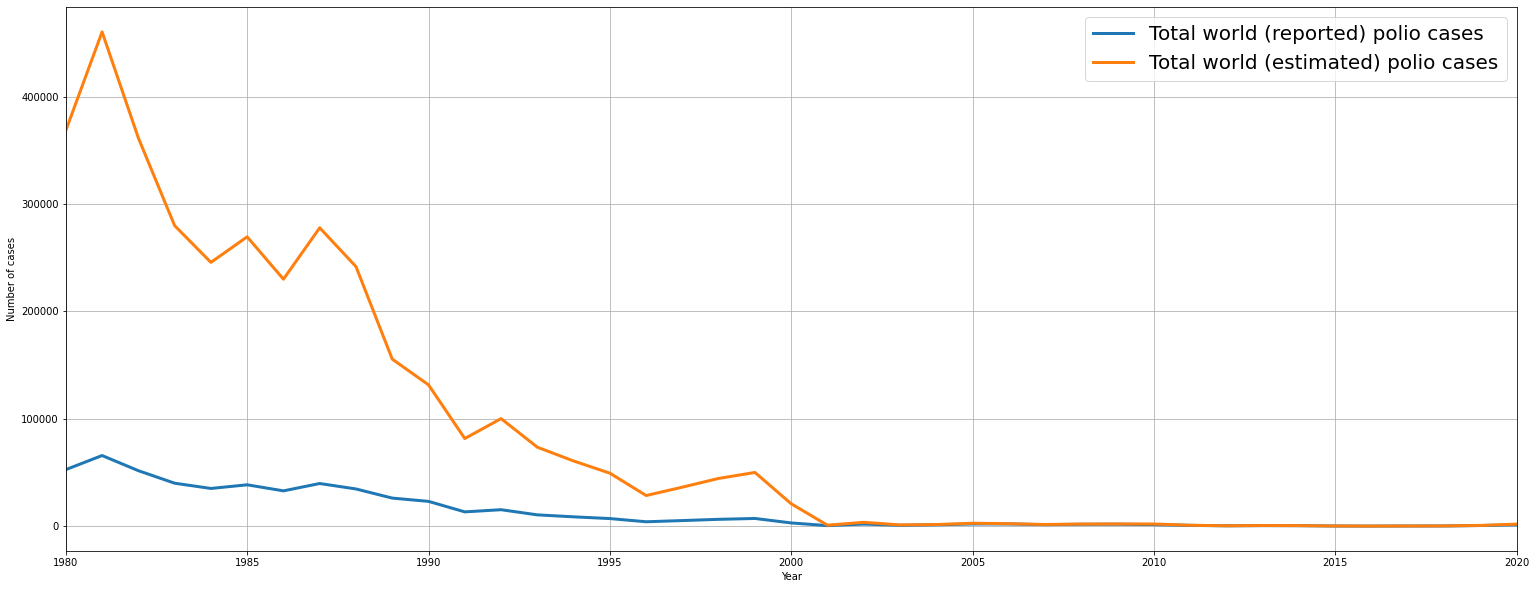

In [4]:
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(world_data['Year'],world_data['Total (reported) polio cases'],linewidth=3)
plt.plot(world_data['Year'],world_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total world (reported) polio cases','Total world (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(world_data['Year']),max(world_data['Year']))
plt.show()

Looking at global data from the past 40 years it seems that polio was successfully stopped, hoever, closer inspection to the past few years is necessary to understand growing problem.

In [5]:
selected_world_data = world_data[-15:]
print(selected_world_data)

    index  Year  Total (reported) polio cases  Total (estimated) polio cases
26   7648  2006                          2022                         2247.0
27   7649  2007                          1387                         1540.0
28   7650  2008                          1736                         1927.0
29   7651  2009                          1787                         2020.0
30   7652  2010                          1412                         1988.0
31   7653  2011                           716                          827.0
32   7654  2012                           293                          326.0
33   7655  2013                           481                          565.0
34   7656  2014                           415                          470.0
35   7657  2015                           106                          140.0
36   7658  2016                            42                           49.0
37   7659  2017                           118                          131.0

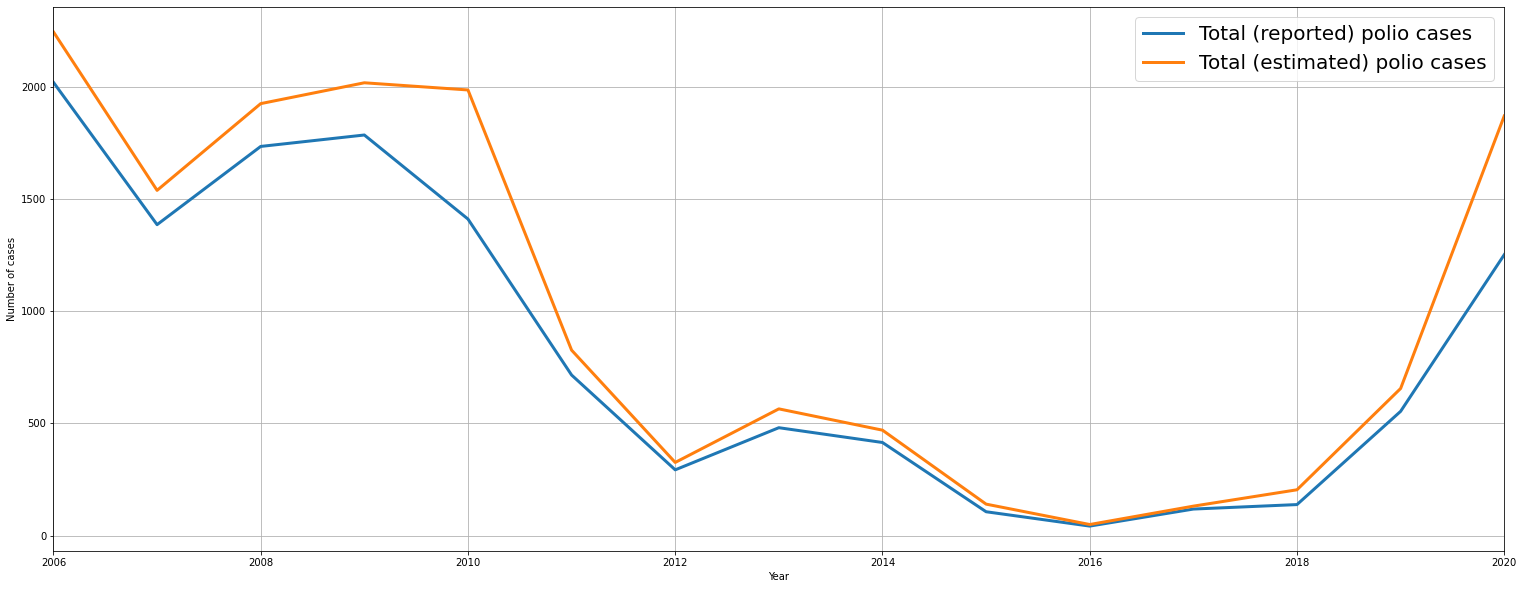

In [6]:
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(selected_world_data['Year'],selected_world_data['Total (reported) polio cases'],linewidth=3)
plt.plot(selected_world_data['Year'],selected_world_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_world_data['Year']),max(selected_world_data['Year']))
plt.show()

As it can be seen in selected period of time, polio is growing rather than stopping

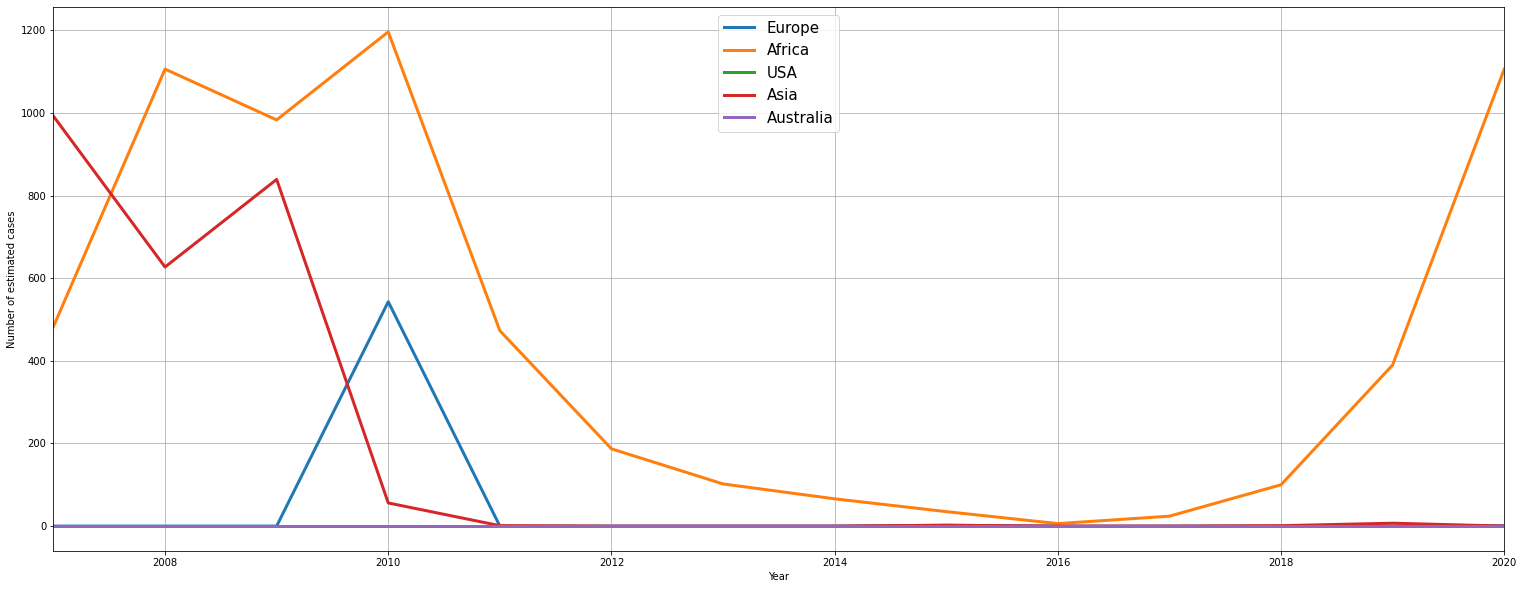

In [7]:
europe_selected_data = imported_data[imported_data['Entity'] == 'Europe'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
africa_selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
states_selected_data = imported_data[imported_data['Entity'] == 'United States'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
asia_selected_data = imported_data[imported_data['Entity'] == 'South-East Asia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
australia_selected_data = imported_data[imported_data['Entity'] == 'Australia'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-15:-1]
plt.figure(figsize=(26, 10))
plt.grid(True)
plt.plot(europe_selected_data['Year'],europe_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(africa_selected_data['Year'],africa_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(states_selected_data['Year'],states_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(asia_selected_data['Year'],asia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.plot(australia_selected_data['Year'],australia_selected_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Europe','Africa','USA','Asia','Australia'], prop={'size': 15})
plt.xlabel('Year')
plt.ylabel('Number of estimated cases')
plt.xlim(min(europe_selected_data['Year']),max(europe_selected_data['Year']))
plt.show()

As it can be seen problem is growing rapidly in Africa. So predictions will be made for Africa and whole world to see comparison.

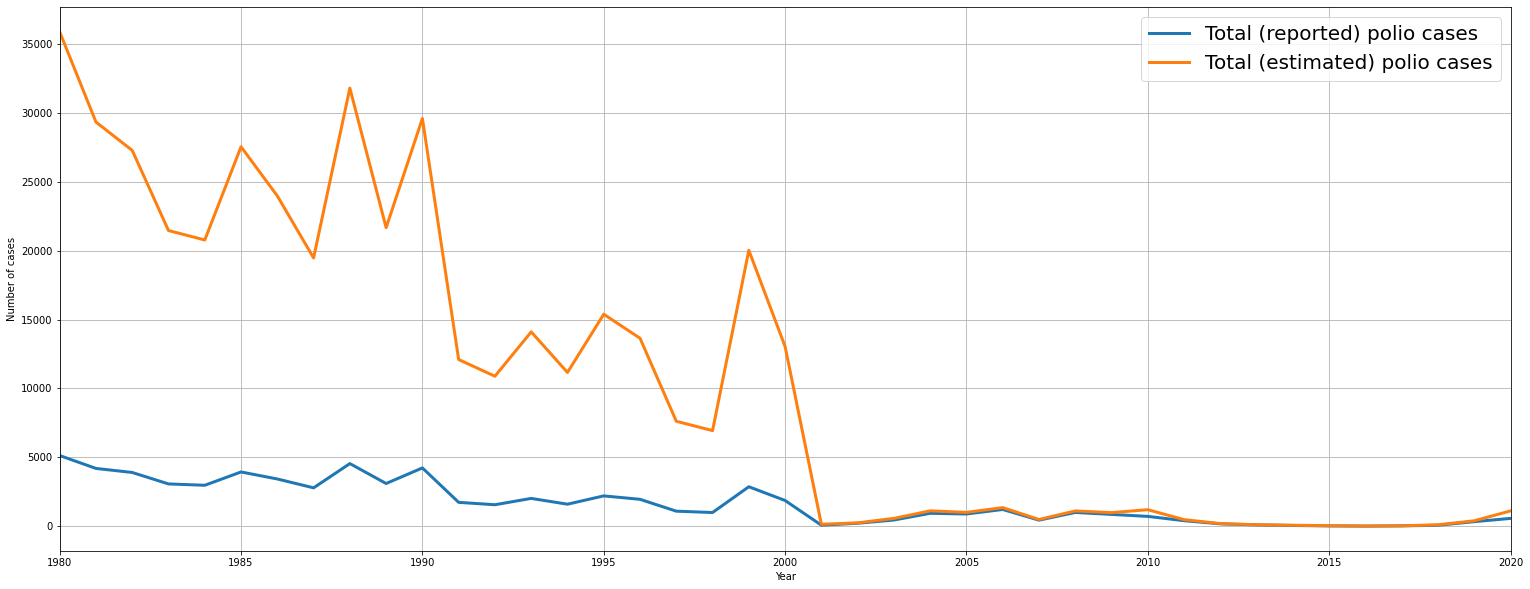

In [8]:
africa_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][:-1]
plt.figure(figsize=(26, 10))
plt.plot(africa_data['Year'],africa_data['Total (reported) polio cases'],linewidth=3)
plt.plot(africa_data['Year'],africa_data['Total (estimated) polio cases'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(africa_data['Year']),max(africa_data['Year']))
plt.grid(True)
plt.show()


Interesting region (last x years)

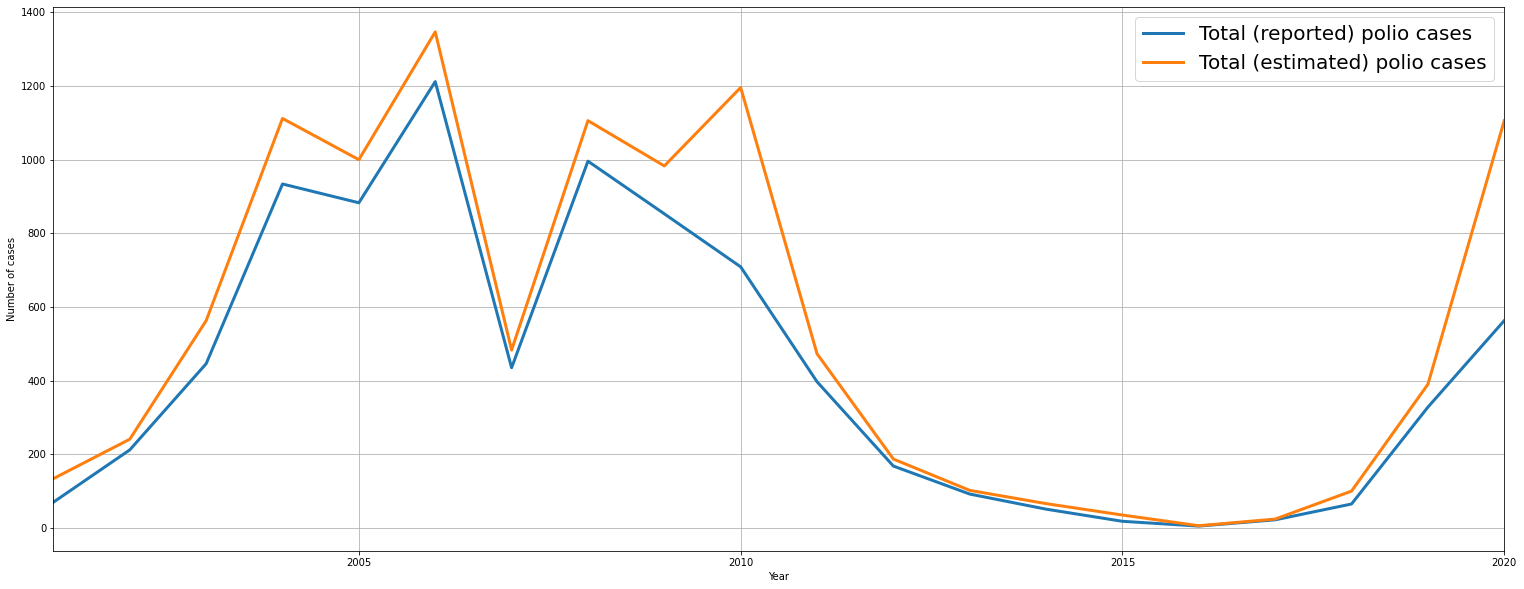

In [9]:
# Selecting data for analysis
n_years = 20
selected_data = imported_data[imported_data['Entity'] == 'Africa'][['Year','Total (reported) polio cases','Total (estimated) polio cases']][-n_years-1:-1]
selected_data.rename(columns = {'Total (reported) polio cases': 'Cases'}, inplace=True)
selected_data.rename(columns= {'Total (estimated) polio cases':'Cases_estimated'}, inplace=True)

plt.figure(figsize=(26, 10))
plt.grid(True)
plt.locator_params(axis="both", integer=True, tight=True)
plt.plot(selected_data['Year'],selected_data['Cases'],linewidth=3)
plt.plot(selected_data['Year'],selected_data['Cases_estimated'],linewidth=3)
plt.legend(['Total (reported) polio cases','Total (estimated) polio cases'], prop={'size': 20})
plt.xlabel('Year')
plt.ylabel('Number of cases')
plt.xlim(min(selected_data['Year']),max(selected_data['Year']))
plt.show()

<h2>Model 1 - Linear regression</h2>
For first model linear regression will be used as it is most commonly programmed
problem is, with changing data scope, all priors must be changed
<br>
<h6>Reference:</h6>

In [10]:
stan_file = "stan_models\\linear_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
    int <lower = 0> N; 
    vector [N] y; //cases
    vector [N] x; //years
    int x_pred; //predicted year
} 
parameters { 
    real alpha; 
    real beta; 
    real mu;
    real <lower = 0> sigma; 
} 
model { 
    alpha ~ normal(0,10); 
    beta ~ normal(0,10);  //From research 
    sigma ~ exponential(1);
    y ~ normal(alpha + beta * x, sigma);
} 
generated quantities{ 
    vector[N] log_lik;
    for(i in 1:N){
        log_lik[i] = normal_lpdf(y[i]|mu, sigma);
    }
    real y_pred = normal_rng(alpha + beta * x_pred , sigma);
} 


INFO:cmdstanpy:found newer exe file, not recompiling


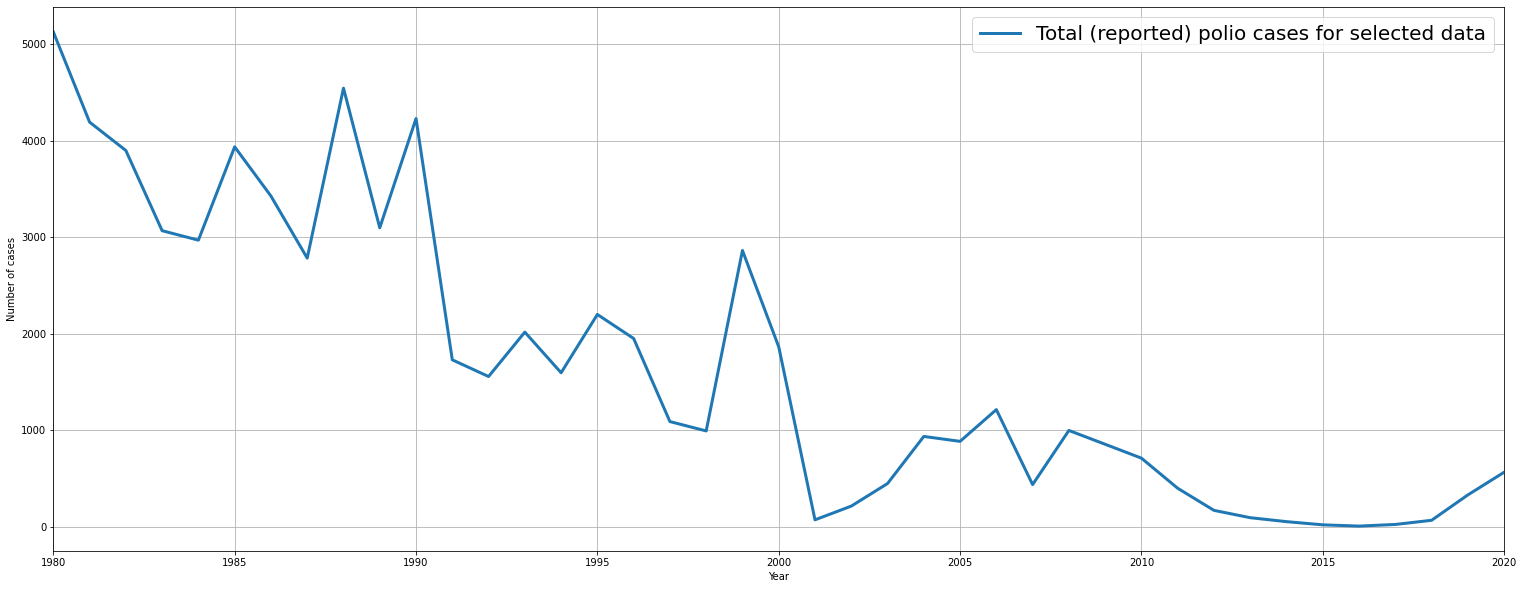

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [11]:
selected_data = select_data('Africa')
plot_selected_data(selected_data)

model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1
                  }

fit_linear_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)

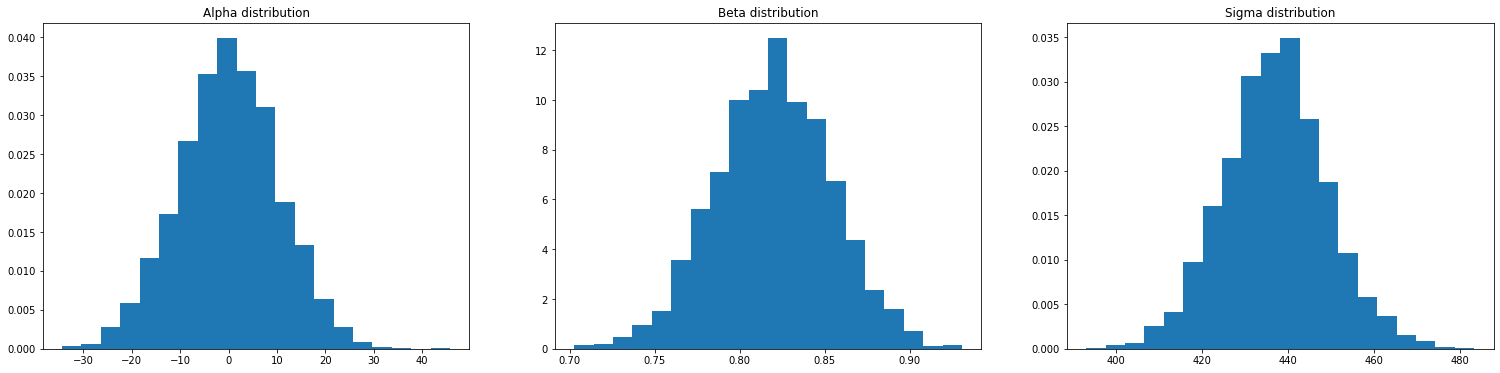

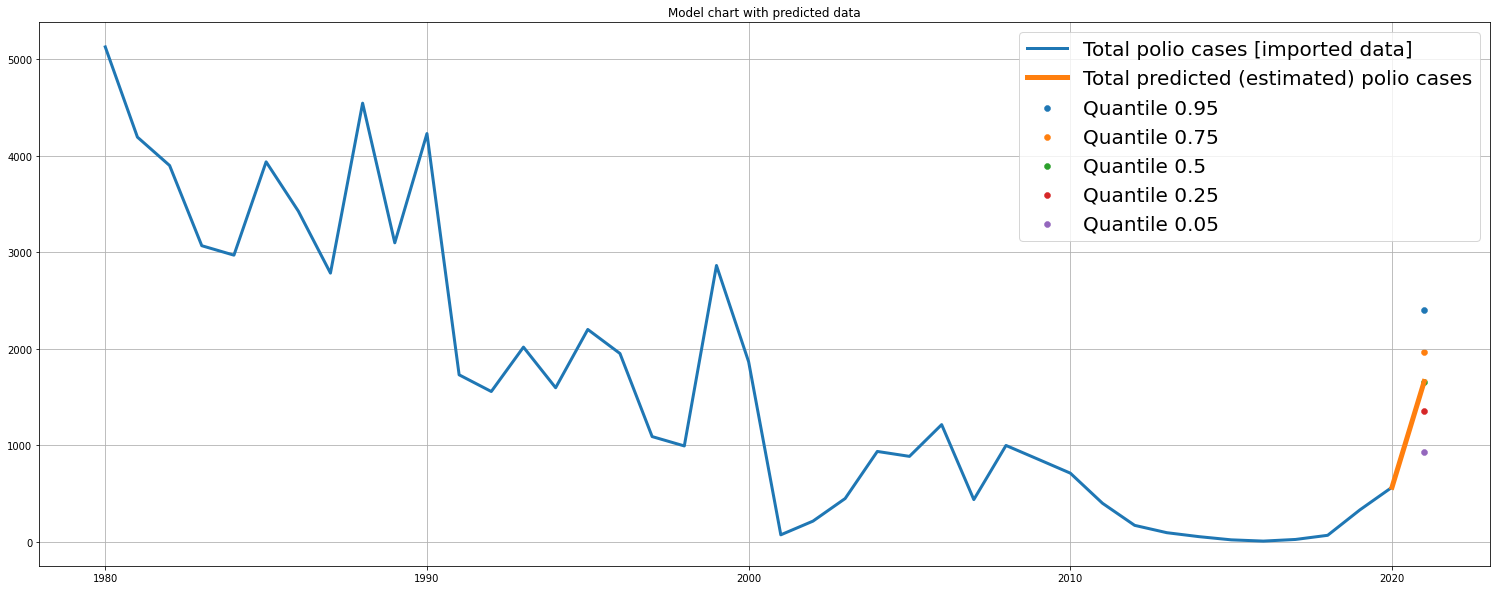

Predicted mean value of Polio cases for year 2021: 1658


In [12]:
plot_distributions(fitted_model=fit_linear_whole)
plot_predictions_chart(selected_data, fit_linear_whole.stan_variable('y_pred'), 2021)

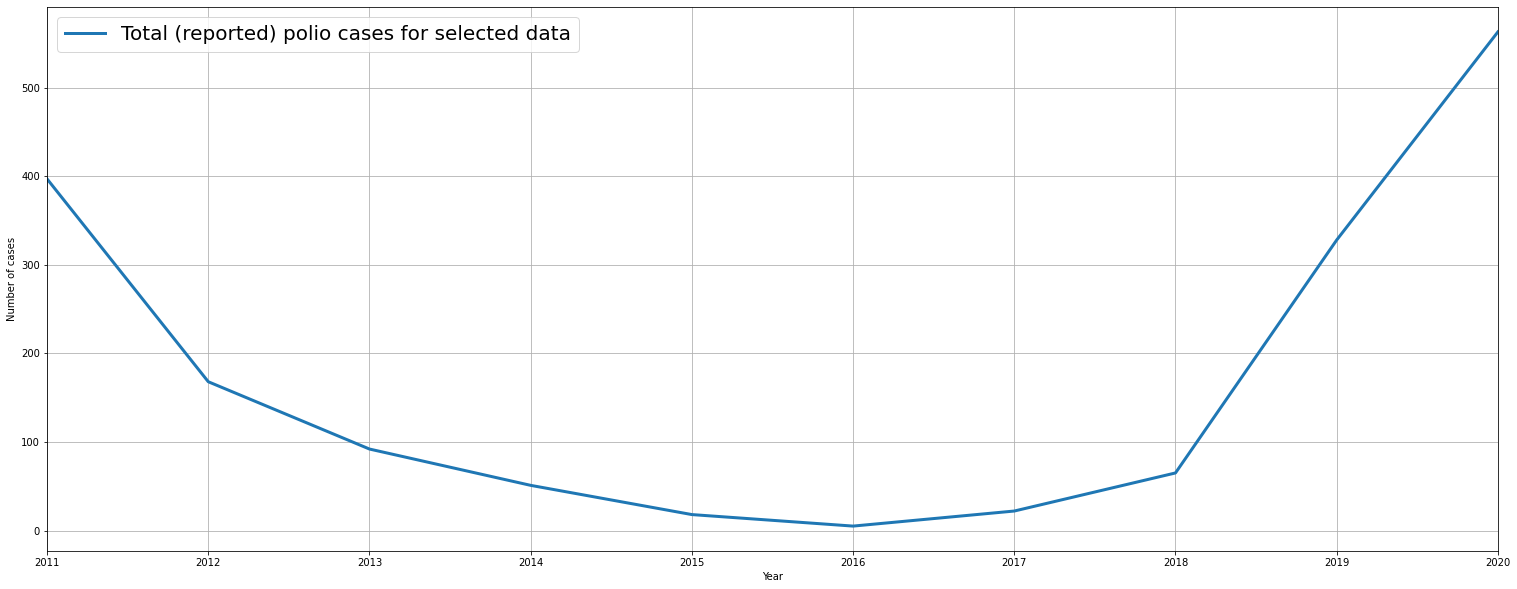

In [13]:
selected_data = select_data('Africa', 10)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


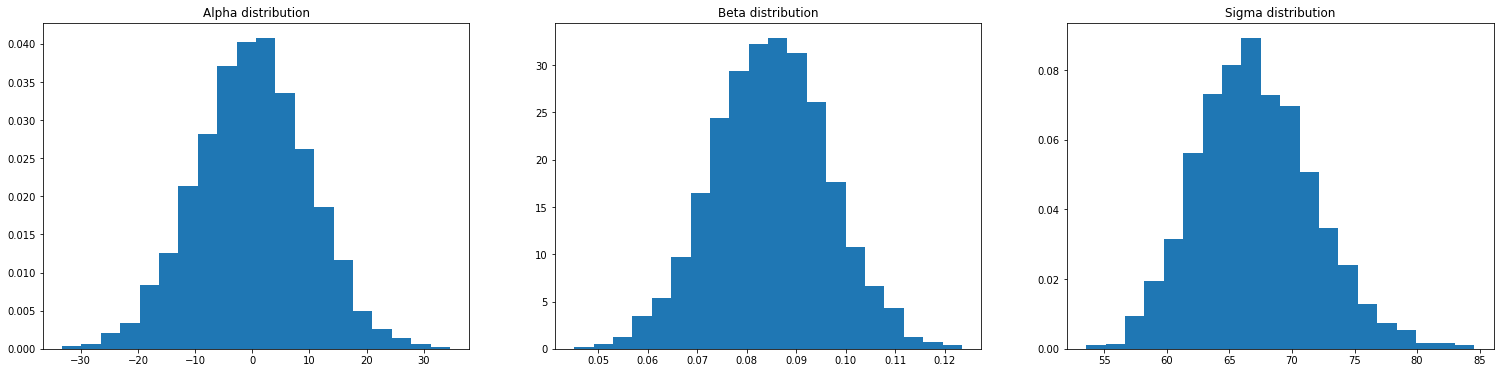

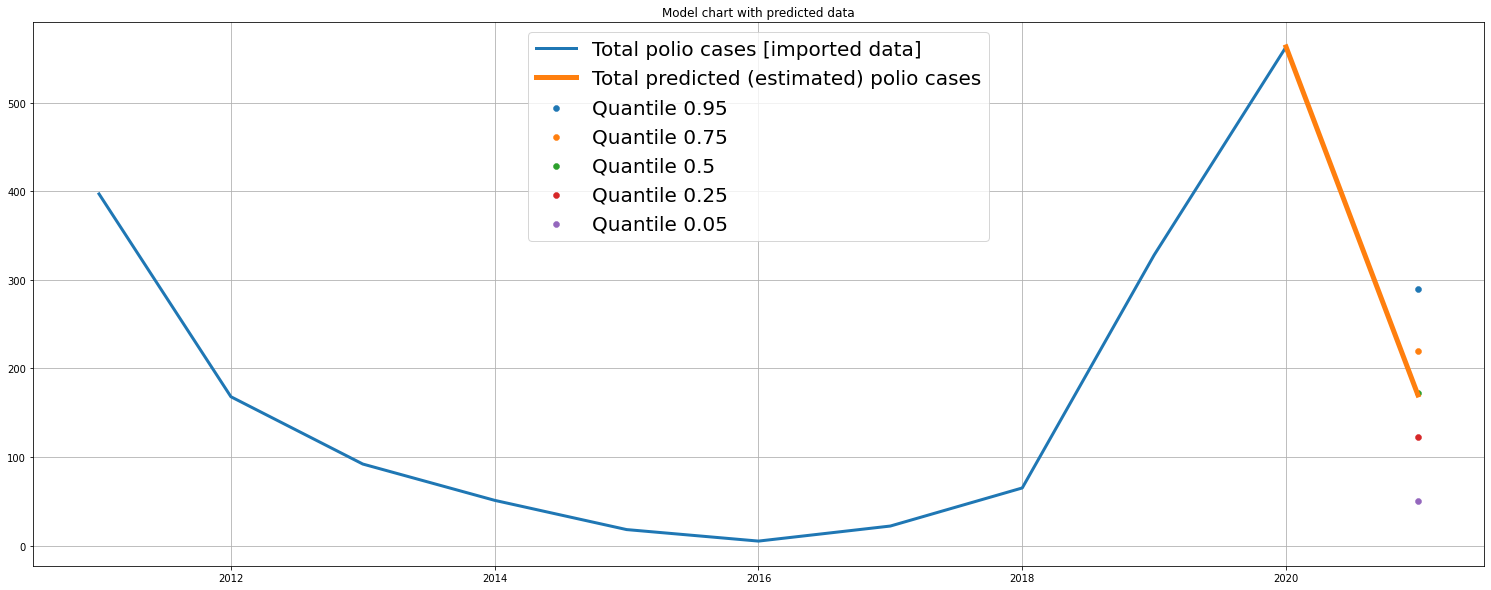

Predicted mean value of Polio cases for year 2021: 170


In [14]:
model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1,
                  }


fit_linear_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_decade)
plot_predictions_chart(selected_data, fit_linear_decade.stan_variable('y_pred'), 2021)

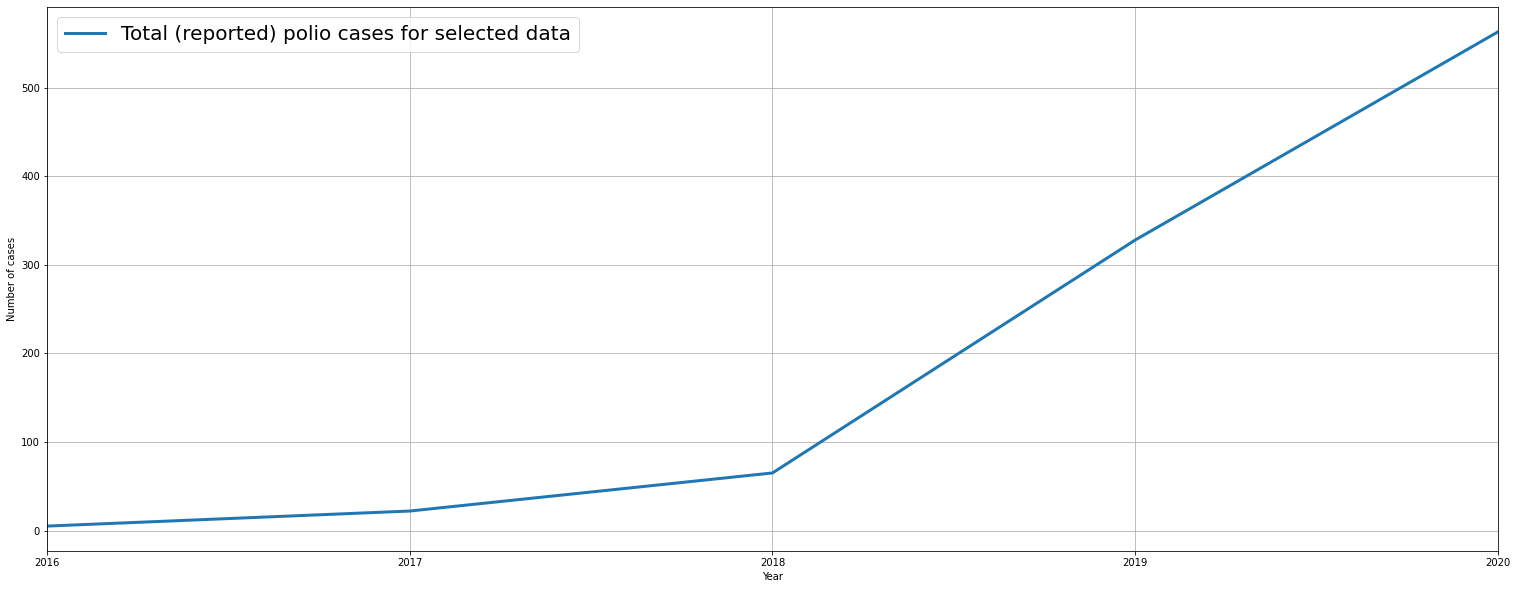

In [15]:
selected_data = select_data('Africa', 5)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


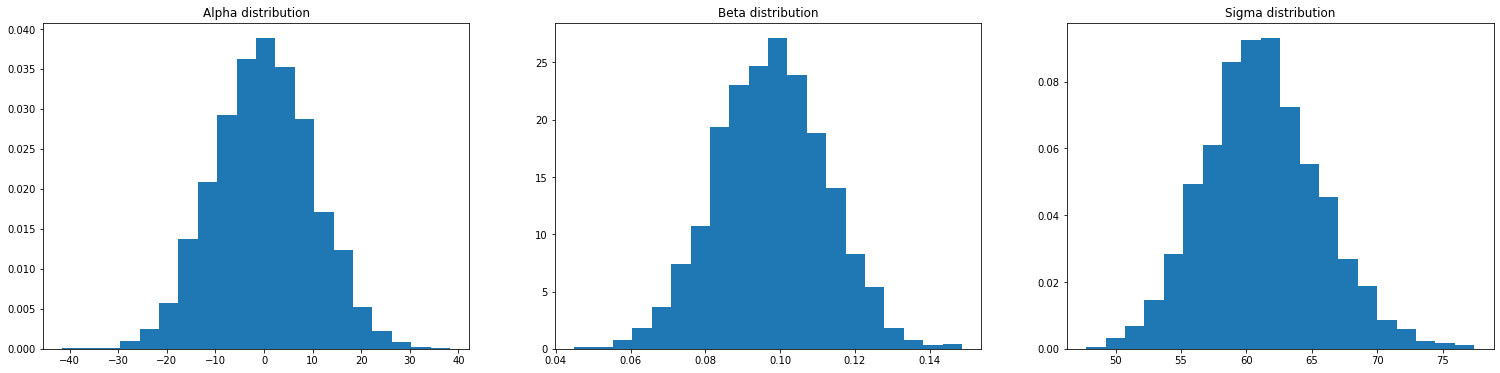

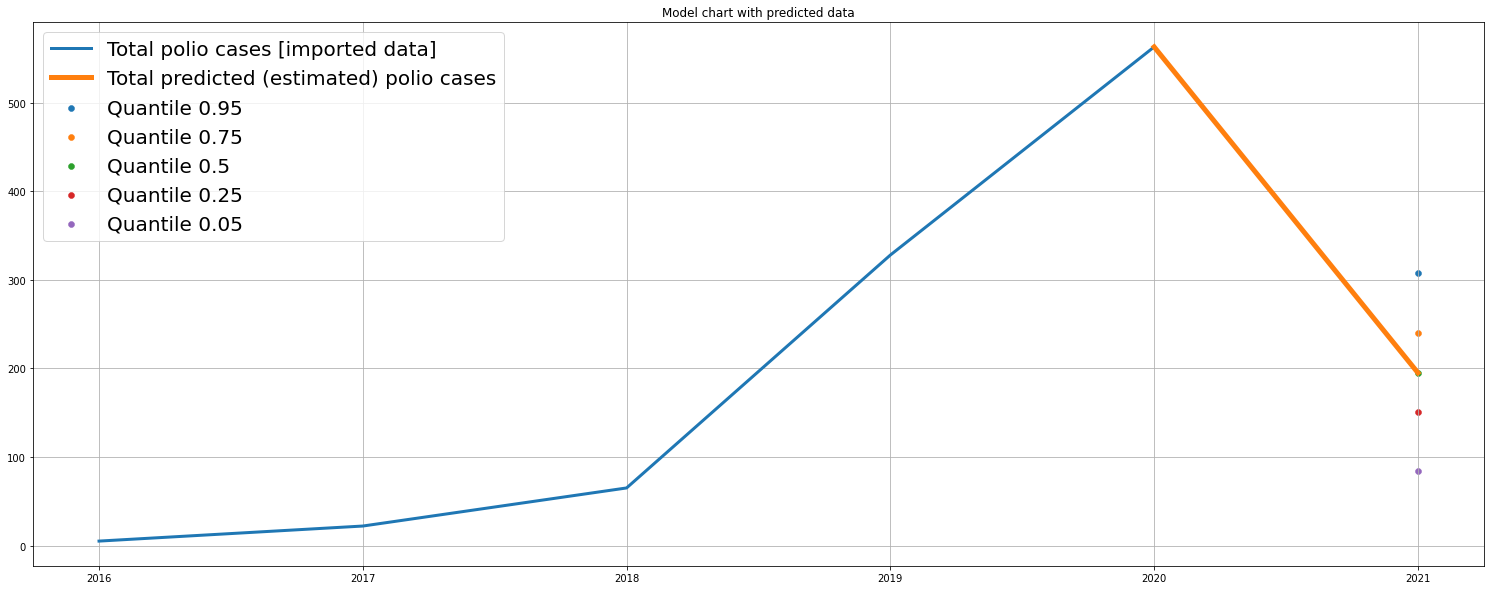

Predicted mean value of Polio cases for year 2021: 195


In [16]:
model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1,
                  }

fit_linear_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_linear_growths)
plot_predictions_chart(selected_data, fit_linear_growths.stan_variable('y_pred'), 2021)

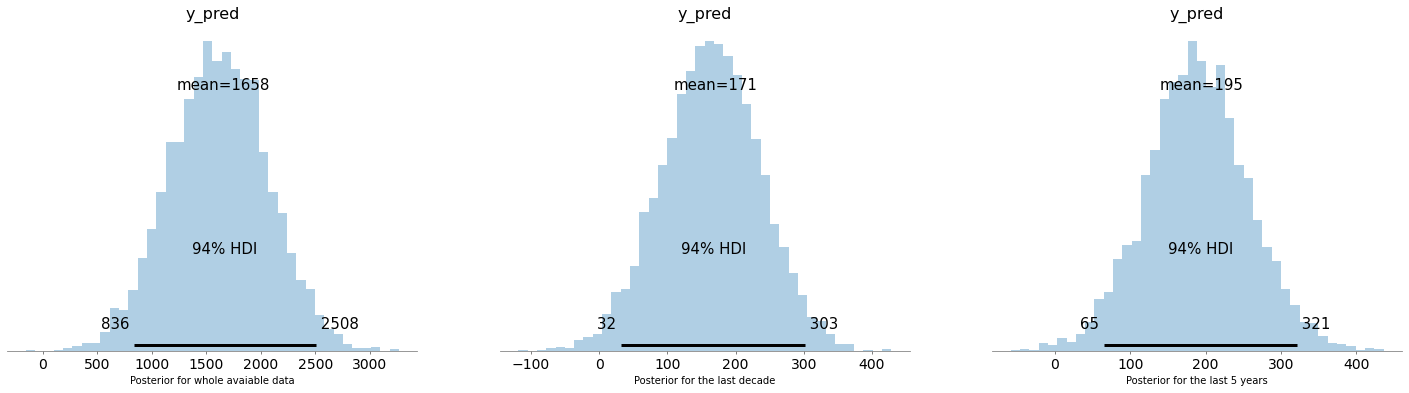

In [78]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

<h2>Model 2 - Autoregressive</h2>
As diesese is strictly connected with active infected people first model will be created on basis of autoregression
Model parameters will be generated by STAN model
<br>
<h6>Reference: https://mc-stan.org/docs/2_23/stan-users-guide/autoregressive-section.html</h6>

In [17]:
stan_file = "stan_models\\autoregressive_model.stan"
with open(stan_file) as file:
    file_content = file.read()
print(file_content)
model = CmdStanModel(stan_file=stan_file)

data { 
  int <lower = 0> N; 
  vector [N] y; 
} 
 
parameters { 
  real alpha; 
  real beta;
  real mu;
  real <lower = 0> sigma; 
} 
model { 
  alpha ~ normal(0,10); 
  beta ~ normal(0,10);  //From research 
  sigma ~ exponential(1);
  for (n in 2:N){
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
  }
} 
generated quantities{ 
  vector[N] log_lik;
  for(i in 1:N){
      log_lik[i] = normal_lpdf(y[i] | mu, sigma);
  }
  real y_pred = normal_rng(alpha + beta * y[N], sigma); 
} 



INFO:cmdstanpy:found newer exe file, not recompiling


Fitting model to whole avaiable data

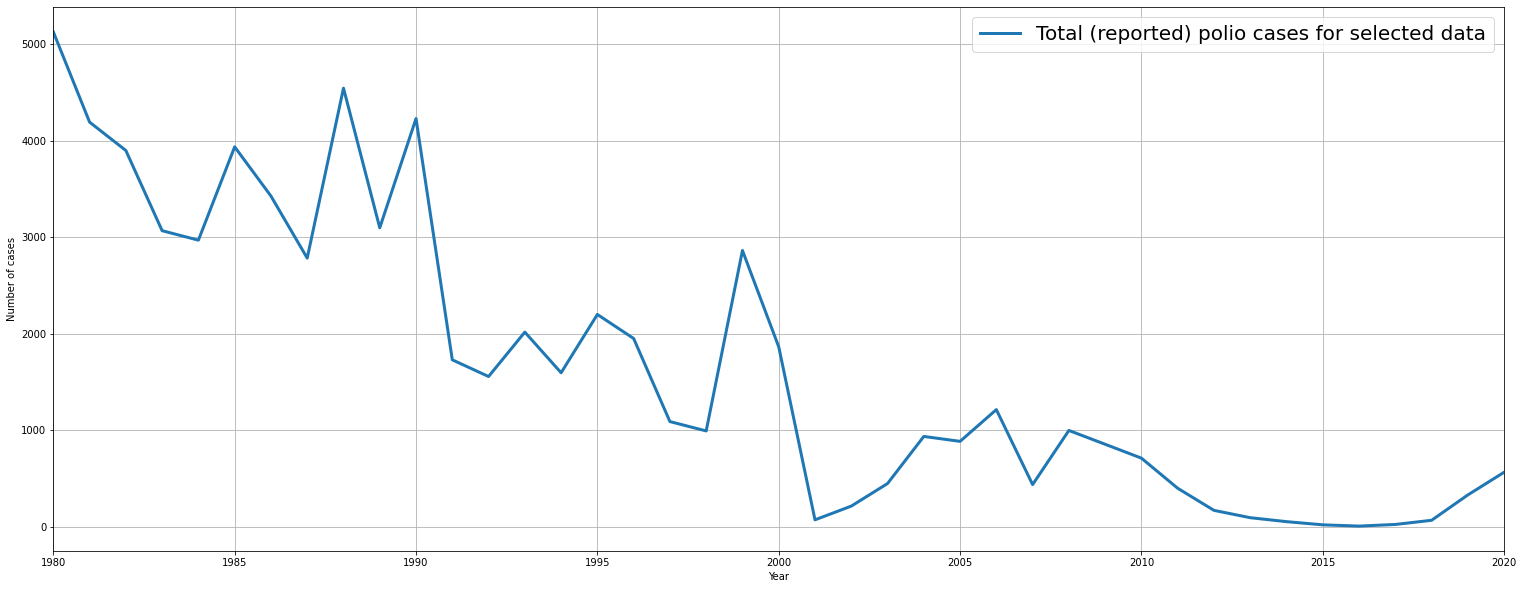

In [18]:
selected_data = select_data('Africa')
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


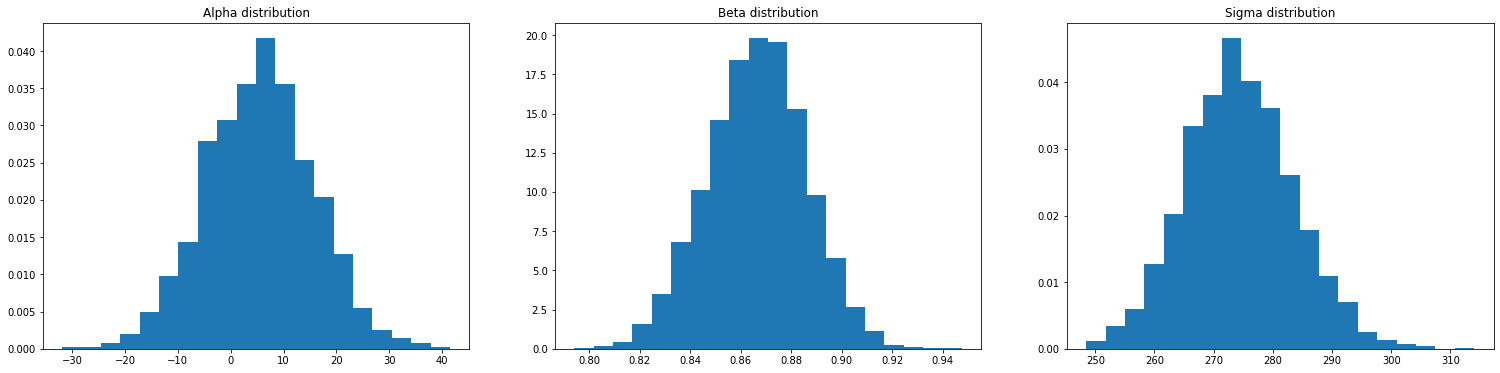

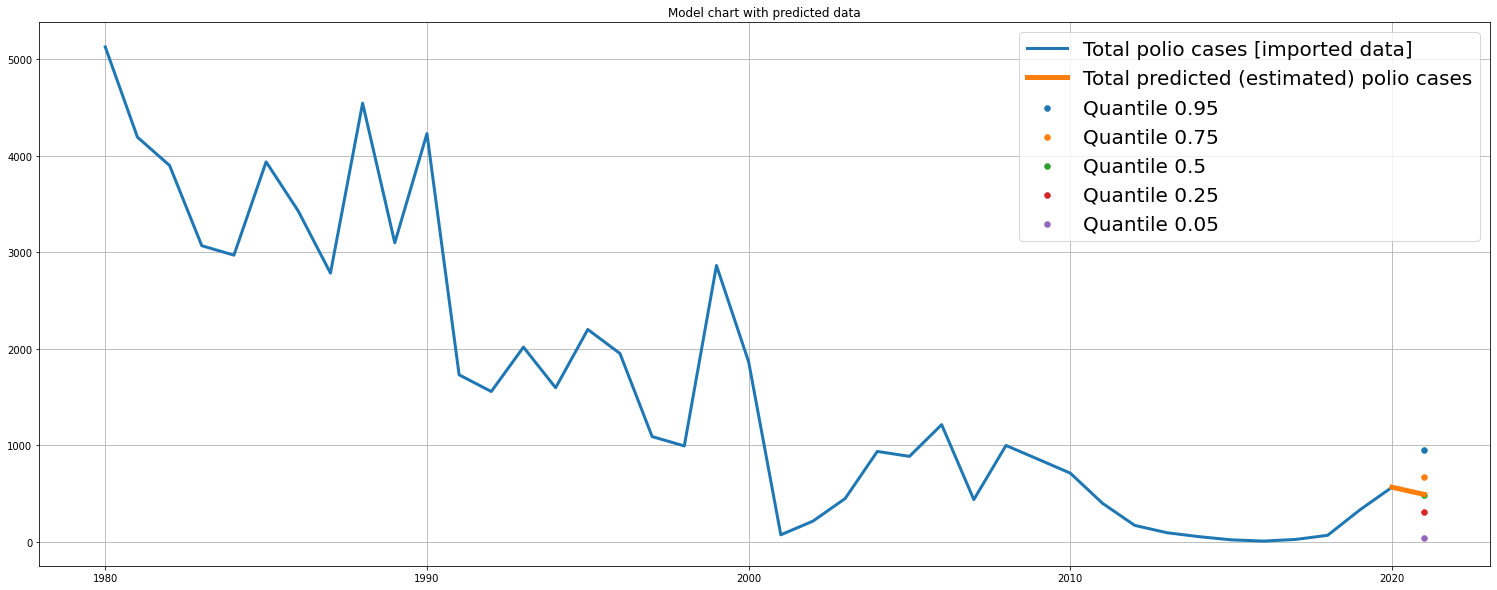

Predicted mean value of Polio cases for year 2021: 489


In [19]:
model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1,
                  }

fit_autoregressive_whole = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_whole)
plot_predictions_chart(selected_data, fit_autoregressive_whole.stan_variable('y_pred'), 2021)

Predictions for last decade (u-shape)

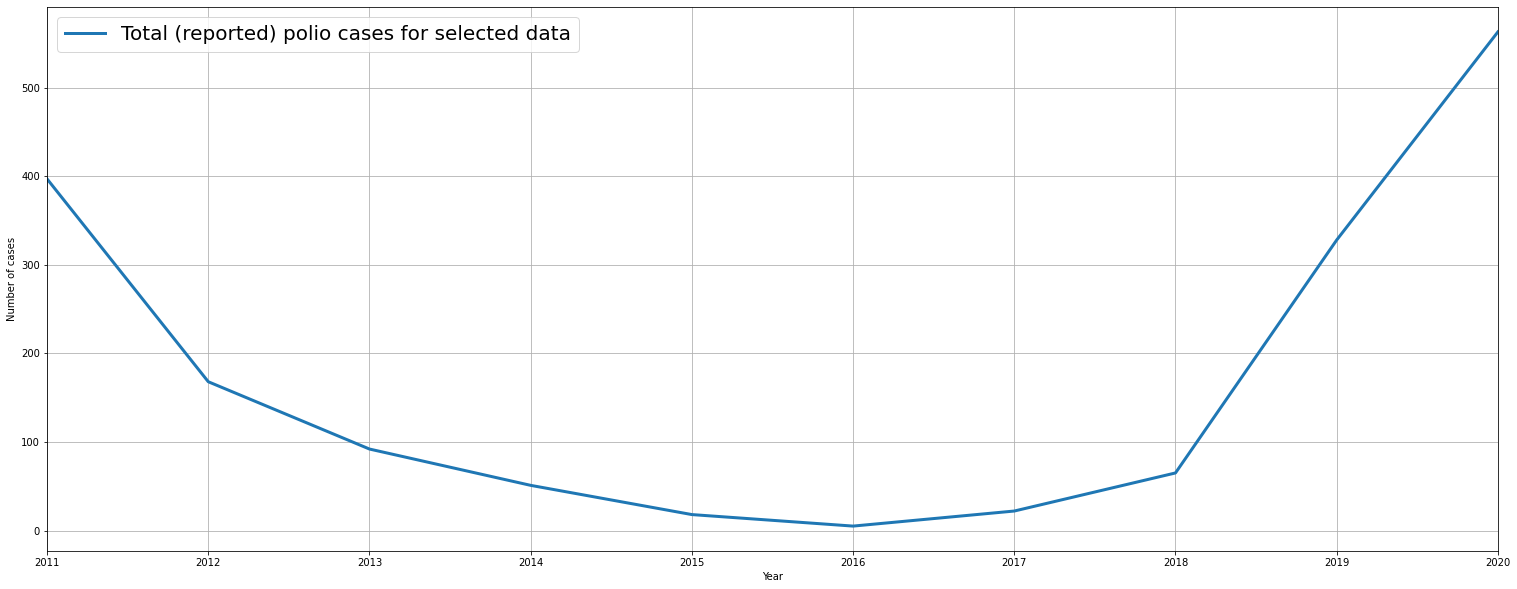

In [20]:
selected_data = select_data('Africa', 10)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


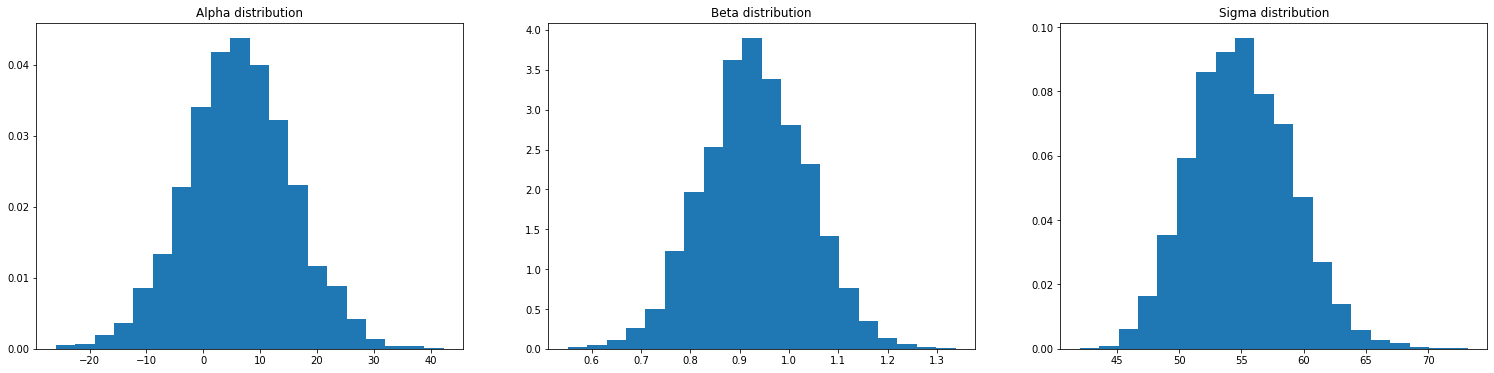

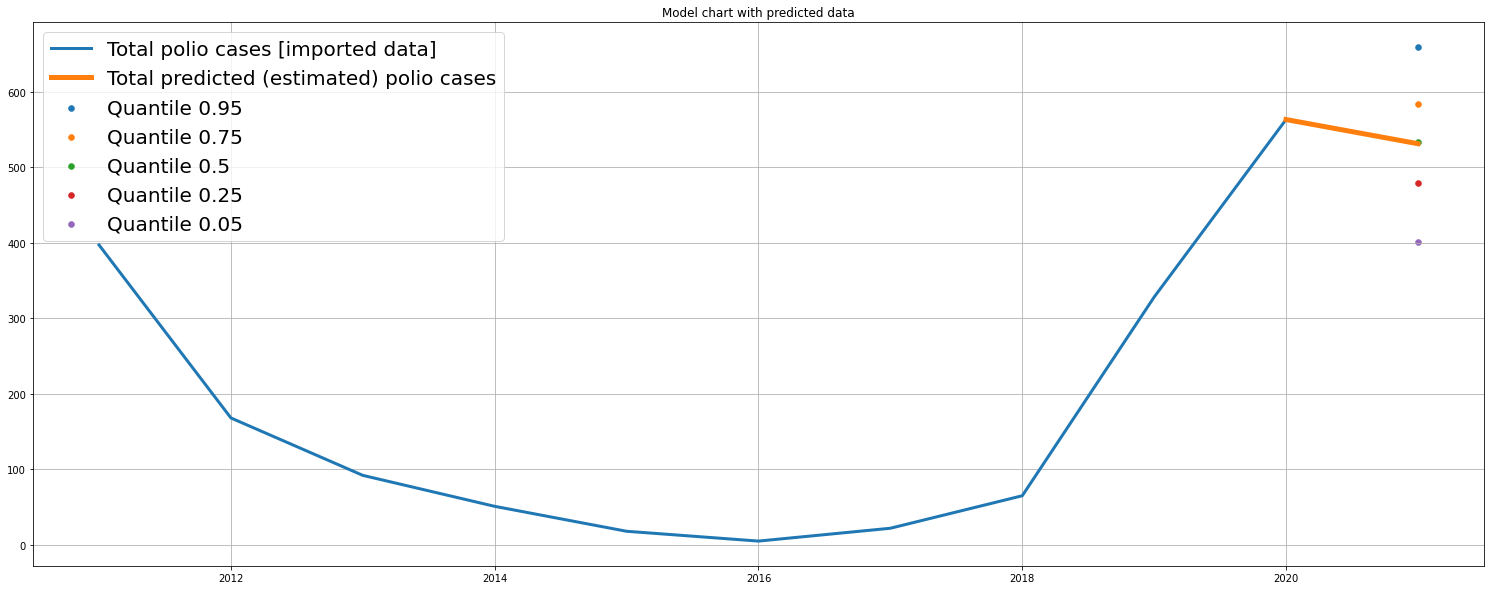

Predicted mean value of Polio cases for year 2021: 531


In [21]:
model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1,
                  }

fit_autoregressive_decade = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_decade)
plot_predictions_chart(selected_data, fit_autoregressive_decade.stan_variable('y_pred'), 2021)

Predictions for last 5 years (just going up)

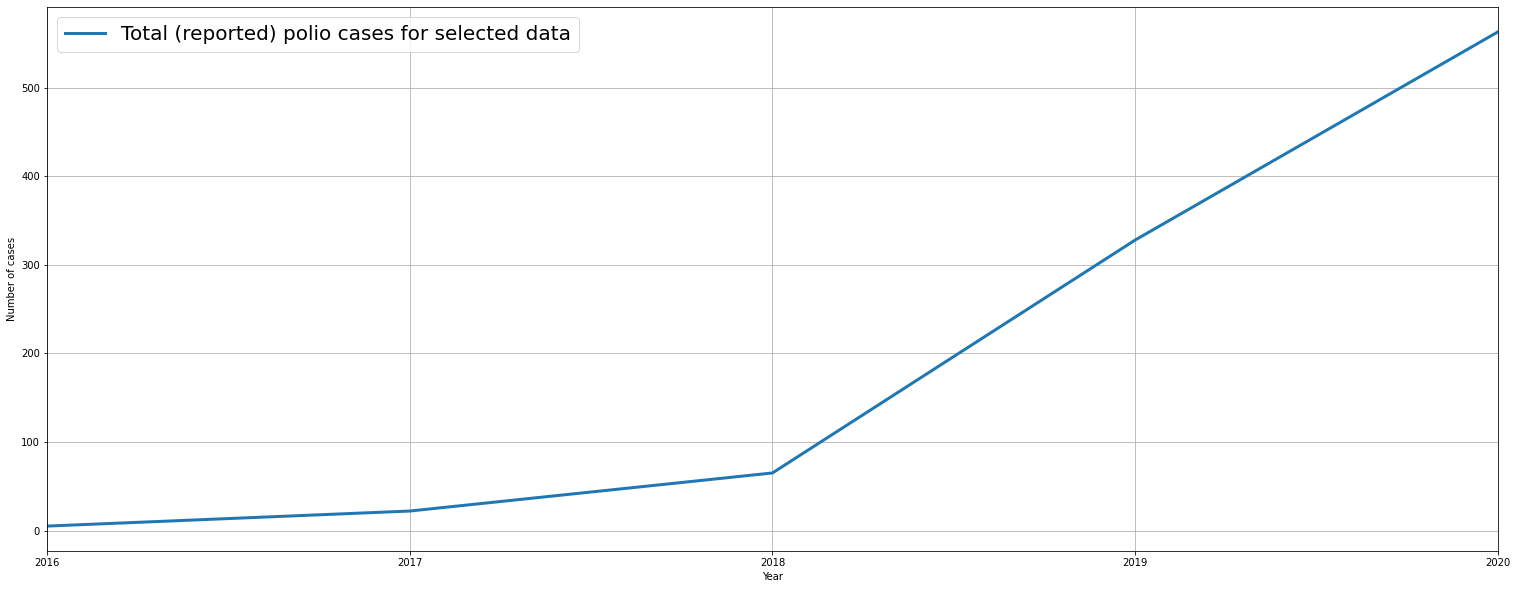

In [22]:
selected_data = select_data('Africa', 5)
plot_selected_data(selected_data)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


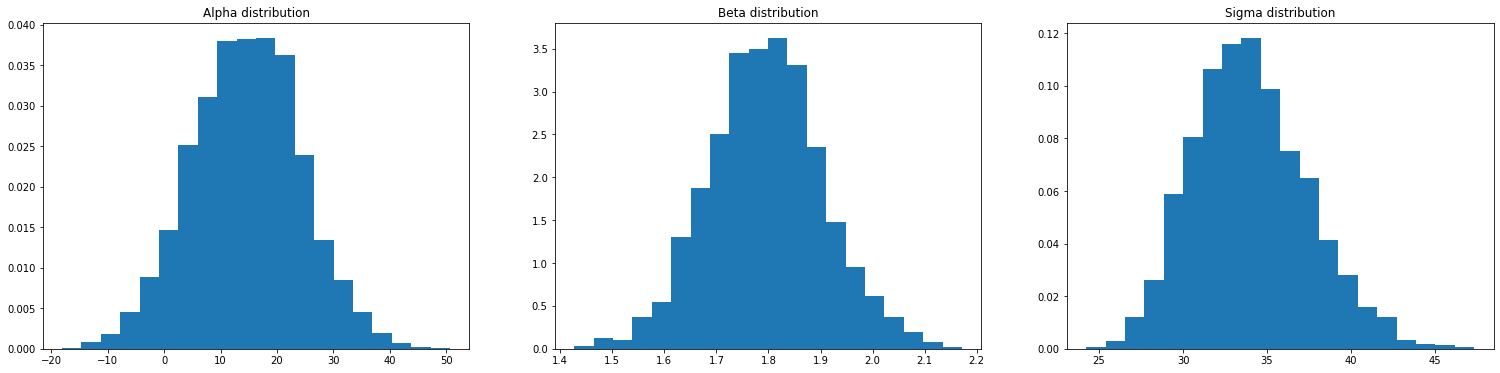

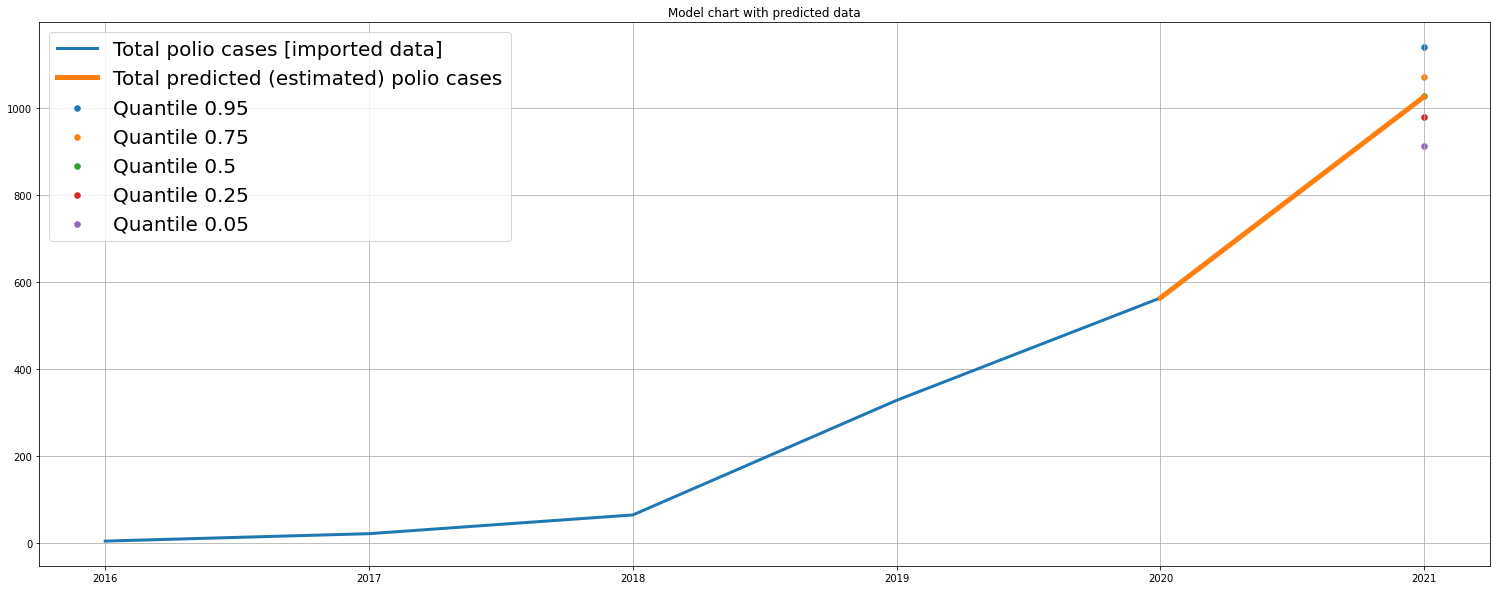

Predicted mean value of Polio cases for year 2021: 1025


In [23]:
model_data_dict = {'N': len(selected_data['Year']),
                    'x': selected_data['Year'],
                    'y': selected_data['Cases'],
                    'x_pred': selected_data['Year'][-1] + 1,
                  }

fit_autoregressive_growths = model.sample(data=model_data_dict, seed = global_seed, iter_sampling=1000)
plot_distributions(fitted_model=fit_autoregressive_growths)
plot_predictions_chart(selected_data, fit_autoregressive_growths.stan_variable('y_pred'), 2021)

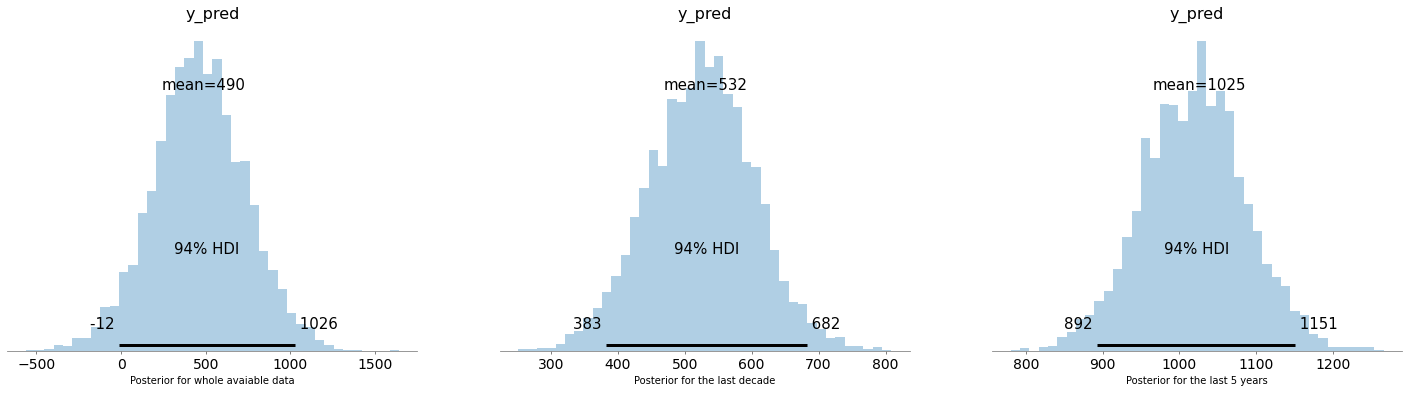

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Posterior for whole avaiable data');
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Posterior for the last decade');
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Posterior for the last 5 years');
plt.show()

<h2>Models comparisons</h2>

c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData\Local\Programs\Python\Python310\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\solar\AppData

                      rank           loo         p_loo         d_loo  weight  \
Autoregressive model     0 -7.327643e+33  7.327643e+33  0.000000e+00     0.5   
Linear model             1 -1.533802e+35  1.533802e+35  1.460525e+35     0.5   

                       se  dse  warning loo_scale  
Autoregressive model  0.0  0.0     True       log  
Linear model          0.0  0.0     True       log  


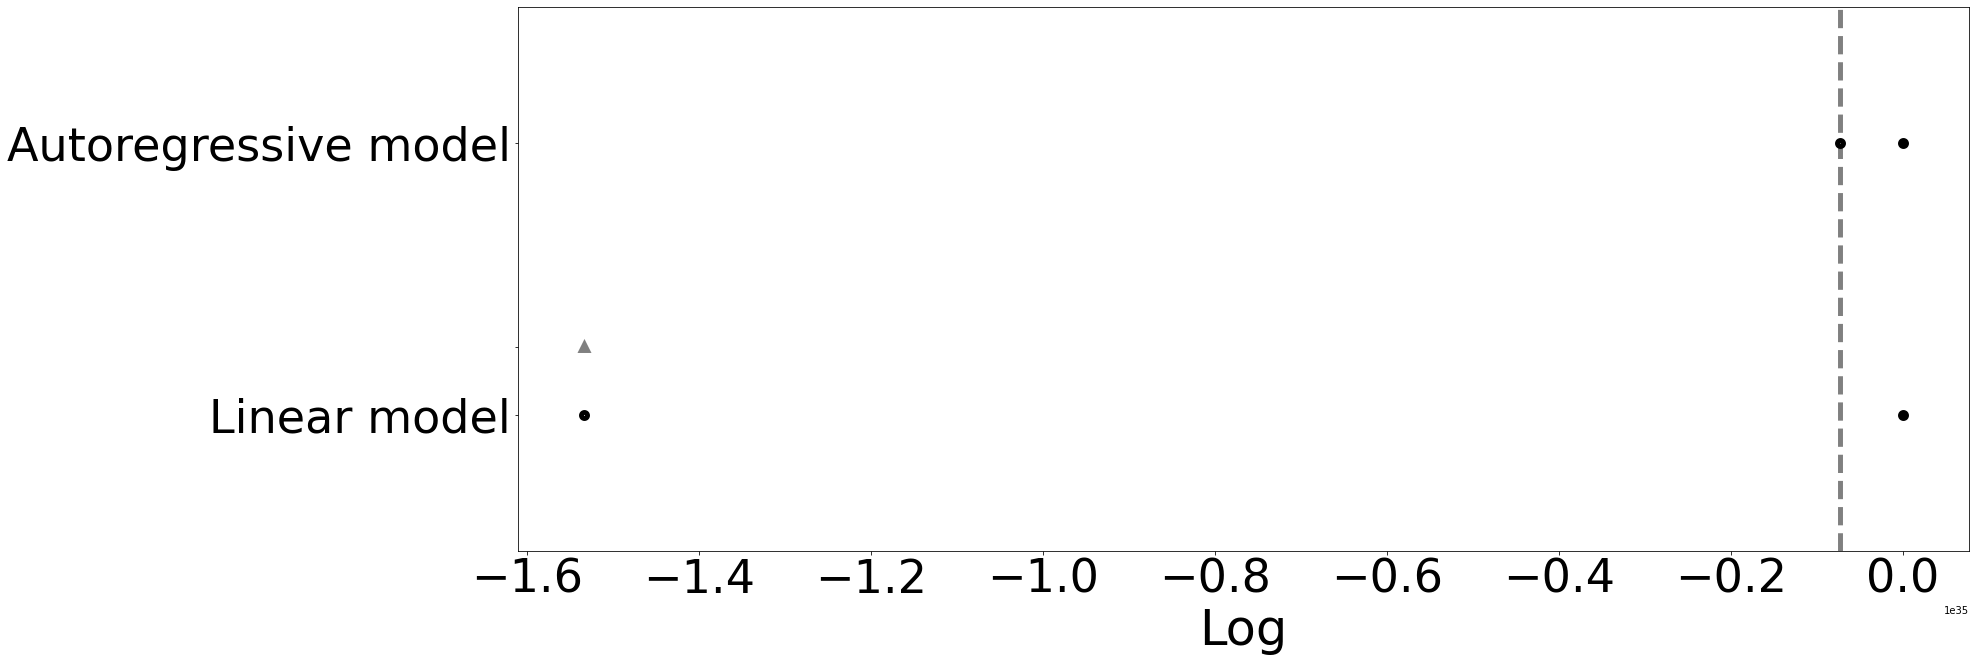

In [81]:
compare_dict = {"Linear model": fit_linear_whole, "Autoregressive model": fit_autoregressive_whole}
comparison = az.compare(compare_dict)
print(comparison)
az.plot_compare(comparison, figsize=(26, 10))
plt.show()

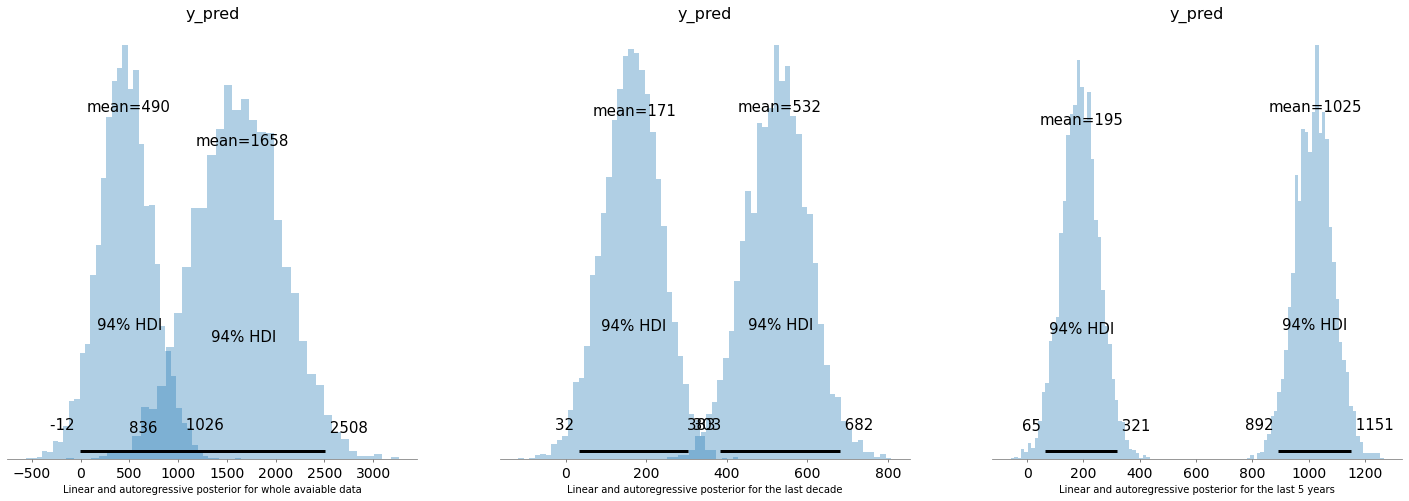

MEAN VALUES:
Linear whole data:  1658
Autoregressive whole data:  489 

Linear last decade:  170
Autoregressive last decade:  531 

Linear last 5 years:  195
Autoregressive last 5 years:  1025 



In [105]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,8))
az.plot_posterior(fit_linear_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
az.plot_posterior(fit_autoregressive_whole, var_names=['y_pred'], kind='hist', bins=40, ax=axs[0])
axs[0].set_xlabel('Linear and autoregressive posterior for whole avaiable data');
az.plot_posterior(fit_linear_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
az.plot_posterior(fit_autoregressive_decade, var_names=['y_pred'], kind='hist', bins=40, ax=axs[1])
axs[1].set_xlabel('Linear and autoregressive posterior for the last decade');
az.plot_posterior(fit_linear_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
az.plot_posterior(fit_autoregressive_growths, var_names=['y_pred'], kind='hist', bins=40, ax=axs[2])
axs[2].set_xlabel('Linear and autoregressive posterior for the last 5 years');
plt.show()
print('MEAN VALUES:')
print('Linear whole data: ', int(np.mean(fit_linear_whole.stan_variable('y_pred'))))
print('Autoregressive whole data: ', int(np.mean(fit_autoregressive_whole.stan_variable('y_pred'))), '\n')
print('Linear last decade: ', int(np.mean(fit_linear_decade.stan_variable('y_pred'))))
print('Autoregressive last decade: ', int(np.mean(fit_autoregressive_decade.stan_variable('y_pred'))), '\n')
print('Linear last 5 years: ', int(np.mean(fit_linear_growths.stan_variable('y_pred'))))
print('Autoregressive last 5 years: ', int(np.mean(fit_autoregressive_growths.stan_variable('y_pred'))), '\n')
